In [24]:
import sqlite3

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import (EarlyStopping, History, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense, Dropout,
                                     Flatten, MaxPooling2D)

In [2]:
# Can this run on GPU
tf.config.list_physical_devices('GPU')

[]

In [3]:
# Constants
RANDOM_STATE = 32  # DO NOT CHANGE, images will have to be resorted
PROCESSED_IMAGES_DIR = "data/images_processed/"
PROCESSED_IMAGE_ARRAY_NPY = "data/image_processed_array.npy"

TRAIN_IMAGES_DIR = "data/train_images/"
TEST_IMAGES_DIR = "data/test_images/"

## Import the data and split for testing and training

In [4]:
# load from SQLite database
connection = sqlite3.connect("data/galaxy_data.sqlite")
df_import = pd.read_sql("SELECT * from galaxy_data", connection)
connection.close()

# Make sure there are no null values in data
df_import.isnull().any(axis=1).sum()

In [6]:
# keep only needed values
stratify_data = df_import["class_reduced"].values
x_image_id_names = df_import["asset_id"]

y_output_data = df_import.drop(["objid", "sample", "asset_id", "dr7objid", "ra", "dec", "gz2_class", "class_reduced"], axis=1)
y_output_data.shape

(239267, 37)

`RANDOM_STATE` needs to be the same as the value in `data_image_cleaning.ipynb`

In [7]:
# Split data into testing and training
# X is asset names, not the actual images
X_train_assets, X_test_assets, y_train, y_test = train_test_split(x_image_id_names,
                                                                  y_output_data,
                                                                  random_state=RANDOM_STATE,
                                                                  stratify=stratify_data)
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [8]:
def load_png_images_from_directory(directory: str,  image_list: list[int]) -> np.array:
    """
    Load grayscale PNG images from a directory into a numpy array.

    Images must be integer names in `image_list`, order is important
    
    :param directory: path to directory
    :param image_list: array of integers representing file names
    :return: array of image arrays
    """
    images = []
    for img_name in image_list:
        img_array = cv2.imread(f"{directory}{img_name}.png", cv2.IMREAD_GRAYSCALE).astype("float32") / 255.0
        images.append(img_array)
    X_image_array = np.array(images)
    return X_image_array

In [9]:
# Load Training images
X_train_images = load_png_images_from_directory(TRAIN_IMAGES_DIR, X_train_assets)
print("X_train_images Shape:", X_train_images.shape)
print("X_train_images Size", X_train_images.nbytes, "bytes")
print("y_train Shape:", y_train.shape)

X_train_images Shape: (179450, 106, 106)
X_train_images Size 8065200800 bytes
y_train Shape: (179450, 37)


In [ ]:
# # create weights with sklearn
# # https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
# class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)  # unique does not make sense for a regression problem

# class_weights = np.sum(y_train, axis=0) / np.sum(y_train)

## Create the Model
This model is a regression model even though is appears to be classifying galaxies. That is because it is really measuring the confidence levels of the group of people classifying the galaxies.

In [10]:
# Callbacks for Early Stopping and Checkpoints
# - https://www.tensorflow.org/tutorials/keras/save_and_load
checkpoints = ModelCheckpoint("data/model/checkpoints/cp-{epoch:04d}.ckpt",
                              monitor="loss", mode="min",
                              save_weights_only=True,
                              verbose=0)
early_stopping = EarlyStopping(monitor="loss", patience=6)

# Callbacks for Reducing Learning Rate
def scheduler(epoch: int, lr: float) -> float:
    """Slightly reduce the learning rate every 10 epochs"""
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.8
    else: # No change
        return lr
    
lr_scheduler = LearningRateScheduler(scheduler, verbose=0)
reduce_lr_plateau = ReduceLROnPlateau(monitor="loss",
                                      factor=0.1, min_lr=0.000_001,
                                      patience=4,
                                      verbose=0)

callbacks_ = [checkpoints, early_stopping, lr_scheduler, reduce_lr_plateau]

In [11]:
# Visualize Loss and Metric over the epochs
history_plt_style = {'axes.edgecolor':'white',
             'axes.facecolor': '#333',
             'axes.labelcolor': 'white',
             'axes.titlecolor': 'white',
             'axes.grid': True,
             'grid.color': '#222',
             'legend.labelcolor': 'white',
             'legend.loc': 'upper right',
             'xtick.color':'white',
             'ytick.color':'white'}

def plot_history(fit_history: History, metric: str, metric_full_name: str):
    """Creates a plot for history of MAE and Loss (MSE)"""
    with plt.rc_context(history_plt_style):
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        fig.patch.set_facecolor('#222')
        # tracked Metric Graph
        axs[0].plot(fit_history.history[metric], label=f'train_{metric}')
        axs[0].plot(fit_history.history[f'val_{metric}'], label=f'val_{metric}')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel(metric_full_name)
        axs[0].legend()
        # Loss Graph
        axs[1].plot(fit_history.history['loss'], label='train_loss')
        axs[1].plot(fit_history.history['val_loss'], label='val_loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss (Mean Squared Error)')
        axs[1].legend()
        plt.show()

In [12]:
IMG_SIZE = X_train_images[0].shape[0]
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

# Create a sequential model
model = Sequential()

# Add convolution layers
model.add(Conv2D(32, (2, 2), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (2, 2), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2, seed=RANDOM_STATE))
# Flatten the output from convolution layers
model.add(Flatten())

# Add dense (fully connected) layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, seed=RANDOM_STATE))

model.add(Dense(64, activation='relu'))

# Add the output layer with 37 units (for 37 classes)
# TODO is `softmax` good for regression, probably relu?
# model.add(Dense(37, activation='softmax'))
model.add(Dense(37, activation='relu'))

# Compile the model
# TODO Since values are like confidence levels from the classifiers, this is really a regression, not a classification
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='mse', metrics=["mae"])  # mse=mean_squared_error

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 105, 105, 32)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 52, 52, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      0

In [ ]:
# Create weight function/array/list to give weight to rare categories
class_weights = {
    0: 1,   # t01_smooth
    1: 1,   # t01_features
    2: 1,   # t01_star_artifact
    3: 1,   # t02_edge_on_yes
    4: 1,   # t02_edge_on_no
    5: 1,   # t03_bar_yes
    6: 1,   # t03_bar_no
    7: 1,   # t04_spiral_yes
    8: 1,   # t04_spiral_no
    9: 1,   # t05_bulge_prominence_no_bulge
    10: 1,  # t05_bulge_prominence_just
    11: 1,  # t05_bulge_prominence_obvious
    12: 1,  # t05_bulge_prominence_dominant
    13: 1,  # t06_odd_yes
    14: 1,  # t06_odd_no
    15: 1,  # t07_rounded_completely_round
    16: 1,  # t07_rounded_in_between
    17: 1,  # t07_rounded_cigar_shaped
    18: 1,  # t08_odd_feature_ring
    19: 1,  # t08_odd_feature_lens_or_arc
    20: 1,  # t08_odd_feature_disturbed
    21: 1,  # t08_odd_feature_irregular
    22: 1,  # t08_odd_feature_other
    23: 1,  # t08_odd_feature_merger
    24: 1,  # t08_odd_feature_dust_lane
    25: 1,  # t09_bulge_shape_rounded
    26: 1,  # t09_bulge_shape_boxy
    27: 1,  # t09_bulge_shape_no_bulge
    28: 1,  # t10_arms_winding_tight
    29: 1,  # t10_arms_winding_medium
    30: 1,  # t10_arms_winding_loose
    31: 1,  # t11_arms_number_1
    32: 1,  # t11_arms_number_2
    33: 1,  # t11_arms_number_3
    34: 1,  # t11_arms_number_4
    35: 1,  # t11_arms_number_more_than_4
    36: 1,  # t11_arms_number_cant_tell
}

### Train the Model

Epoch 1/5
81/81 [==============================] - 543s 6s/step - loss: 0.1003 - mae: 0.2178 - val_loss: 0.0846 - val_mae: 0.2037 - lr: 0.0010
Epoch 2/5
81/81 [==============================] - 372s 5s/step - loss: 0.0823 - mae: 0.1971 - val_loss: 0.0771 - val_mae: 0.1880 - lr: 0.0010
Epoch 3/5
81/81 [==============================] - 284s 3s/step - loss: 0.0777 - mae: 0.1881 - val_loss: 0.0742 - val_mae: 0.1814 - lr: 0.0010
Epoch 4/5
81/81 [==============================] - 359s 4s/step - loss: 0.0747 - mae: 0.1822 - val_loss: 0.0711 - val_mae: 0.1771 - lr: 0.0010
Epoch 5/5
81/81 [==============================] - 303s 4s/step - loss: 0.0720 - mae: 0.1772 - val_loss: 0.0689 - val_mae: 0.1731 - lr: 0.0010


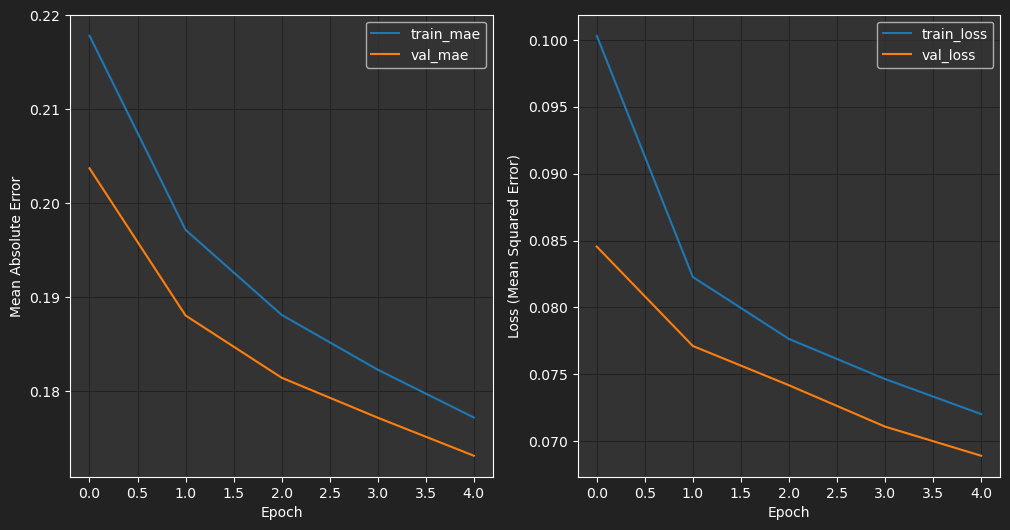

In [13]:
history = model.fit(X_train_images,
                    y_train,
                    # class_weight=class_weights,
                    epochs=5,
                    callbacks=callbacks_,
                    batch_size=2_000,
                    validation_split=0.1)

# Plots
plot_history(history, "mae", "Mean Absolute Error")

In [ ]:
model.save("data/model/GalaxyConfidenceModel.keras")
print("Saved Model!")

---
## Continue Training if Needed
Set `initial_epoch` and increase `epochs` to new final value

In [ ]:
model = load_model("data/model/GalaxyConfidenceModel.keras")
print("Model loaded!")

Epoch 6/11
81/81 [==============================] - 565s 5s/step - loss: 0.0700 - mae: 0.1730 - val_loss: 0.0668 - val_mae: 0.1664 - lr: 0.0010
Epoch 7/11
81/81 [==============================] - 306s 4s/step - loss: 0.0686 - mae: 0.1702 - val_loss: 0.0660 - val_mae: 0.1664 - lr: 0.0010
Epoch 8/11
81/81 [==============================] - 318s 4s/step - loss: 0.0673 - mae: 0.1678 - val_loss: 0.0650 - val_mae: 0.1621 - lr: 0.0010
Epoch 9/11
81/81 [==============================] - 508s 6s/step - loss: 0.0663 - mae: 0.1660 - val_loss: 0.0641 - val_mae: 0.1612 - lr: 0.0010
Epoch 10/11
81/81 [==============================] - 447s 5s/step - loss: 0.0656 - mae: 0.1644 - val_loss: 0.0636 - val_mae: 0.1608 - lr: 0.0010
Epoch 11/11
81/81 [==============================] - 368s 4s/step - loss: 0.0647 - mae: 0.1628 - val_loss: 0.0629 - val_mae: 0.1577 - lr: 8.0000e-04


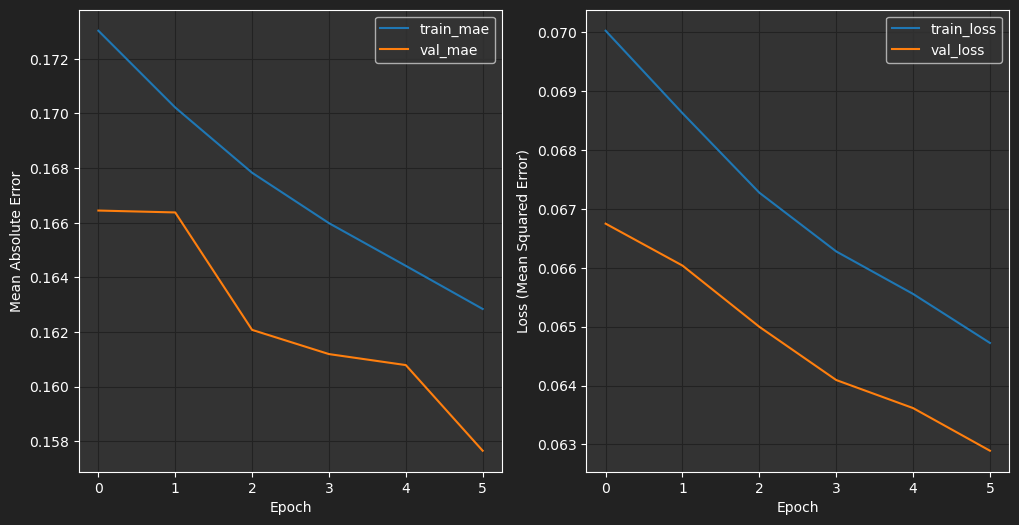

In [17]:
# Continue training model
history = model.fit(X_train_images,
                    y_train,
                    initial_epoch=5,    # TODO Set ending epoch from previous training
                    epochs=11,          # Total Epochs (new + previous)
                    callbacks=callbacks_,
                    batch_size=2_000,
                    validation_split=0.1)

# Plots
plot_history(history, "mae", "Mean Absolute Error")

In [21]:
model.save("data/model/GalaxyConfidenceModel.keras")
print("Saved Updated Model!")

Saved!


---

## Test the model

In [14]:
X_test_images = load_png_images_from_directory(TEST_IMAGES_DIR, X_test_assets)
print("X_test_images Shape:", X_test_images.shape)
print("X_test_images Size", X_test_images.nbytes, "bytes")
print("y_test Shape:", y_test.shape)

X_test_images Shape: (59817, 106, 106)
X_test_images Size 2688415248 bytes
y_test Shape: (59817, 37)


In [18]:
# Evaluate the model using the test data
# model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
model_loss, model_metrics = model.evaluate(X_test_images, y_test, verbose=2)
print(f"Loss: {model_loss}, Metrics: {model_metrics}")

1870/1870 - 26s - loss: 0.0628 - mae: 0.1577 - 26s/epoch - 14ms/step
Loss: 0.06281665712594986, Metrics: 0.1577344387769699


---

## Make Predictions

In [19]:
# This is a face on Barred Spiral Galaxy with 2 arms. It has been scaled down and has very distinct features
predict_img = cv2.imread(r"C:\Users\Zachary\Documents\UTB\Classwork\Project4\examples\test_spiral_bar_2_arm_EDIT.png", cv2.IMREAD_GRAYSCALE).astype("float32") / 255.0
predict_img = np.expand_dims(predict_img, axis=0)  # I do not know why these are necessary but they are
predict_img = np.expand_dims(predict_img, axis=3)  # ^
print(predict_img.shape)
predictions = model.predict(predict_img)
S_predict = pd.Series(predictions[0], y_output_data.columns.values)
S_predict

(1, 106, 106, 1)
1/1 [==============================] - 0s 46ms/step


t01_smooth_or_features_a01_smooth_debiased              0.000000
t01_smooth_or_features_a02_features_or_disk_debiased    0.817381
t01_smooth_or_features_a03_star_or_artifact_debiased    0.000000
t02_edgeon_a04_yes_debiased                             0.000000
t02_edgeon_a05_no_debiased                              1.074219
t03_bar_a06_bar_debiased                                0.316690
t03_bar_a07_no_bar_debiased                             0.873817
t04_spiral_a08_spiral_debiased                          0.616769
t04_spiral_a09_no_spiral_debiased                       0.499275
t05_bulge_prominence_a10_no_bulge_debiased              0.000000
t05_bulge_prominence_a11_just_noticeable_debiased       0.447836
t05_bulge_prominence_a12_obvious_debiased               0.383502
t05_bulge_prominence_a13_dominant_debiased              0.048664
t06_odd_a14_yes_debiased                                0.816670
t06_odd_a15_no_debiased                                 0.385262
t07_rounded_a16_completel